## 개요
- 타이타닉 대회 데이터를 활용하여 ML 모형을 만들 수 있다. 
- MLFlow에 저장한 모델을 불러와서 예측을 할 수 있다. 
- 제출 파일을 만들어서 제출해본다. 

In [13]:
# 코드
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

print(f"numpy version: {np.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"matplotlib version: {matplotlib.__version__}")
print(f"seaborn version: {sns.__version__}")
print(f"sklearn version: {sklearn.__version__}")

numpy version: 1.26.1
pandas version: 2.1.1
matplotlib version: 3.8.0
seaborn version: 0.13.0
sklearn version: 1.3.1


## 데이터 불러오기
- 3개의 데이터를 불러오도록 한다. 

In [14]:
# 코드
import os
os.getcwd()

DATA_PATH = 'C:\\Users\\MSYUN\\Desktop\\ml_optuna_mlflow\\data\\titanic\\'
train_df = pd.read_csv(DATA_PATH + "train.csv")
test = pd.read_csv(DATA_PATH + "test.csv")
submission = pd.read_csv(DATA_PATH + "gender_submission.csv")

train_df.shape, test.shape, submission.shape

((891, 12), (418, 11), (418, 2))

## 데이터 탐색
- 먼저 컬럼명과 데이터타입을 확인한다. 

In [15]:
# 코드
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


- 우선 Age, Cabin, Embarked 컬럼을 보면 결측치가 존재하는 것을 확인할 수 있다. 
- 결측치의 구체적인 갯수를 확인해본다. 

In [16]:
# 코드
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## 데이터 시각화
- 종속변수는 Survived이다. Survived를 기점으로 시각화를 진행한다. 
- 숫자 1은 생존을 의미하고, 0은 사망을 의미한다. 

In [17]:
# 코드
survived = train_df[train_df['Survived'] == 1]
deceased = train_df[train_df['Survived'] == 0]

survived.shape, deceased.shape

((342, 12), (549, 12))

In [18]:
# 코드
class_counts = train_df['Survived'].value_counts(sort=True)
class_counts

Survived
0    549
1    342
Name: count, dtype: int64

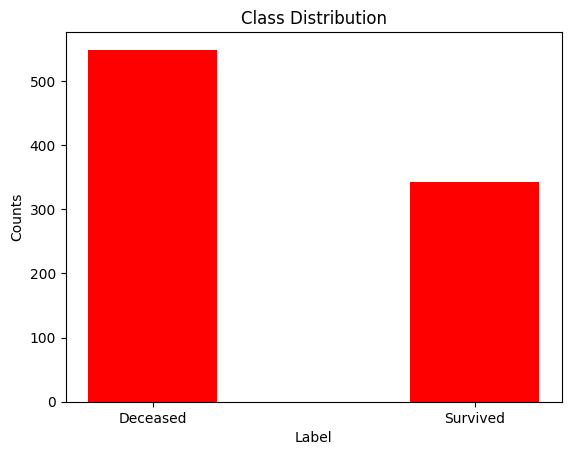

In [19]:
fig, ax = plt.subplots()
ax.bar(class_counts.index, class_counts.values, color="r", width=0.4)
ax.set_xticks([0, 1], ["Deceased", "Survived"])
ax.set_xlabel("Label")
ax.set_ylabel("Counts")
ax.set_title("Class Distribution")
plt.show()

- 연령별 분포를 보도록 한다. 
- 대체적으로 연령별로는 구분이 쉽게 되지는 않는 것을 확인할 수 있다. 

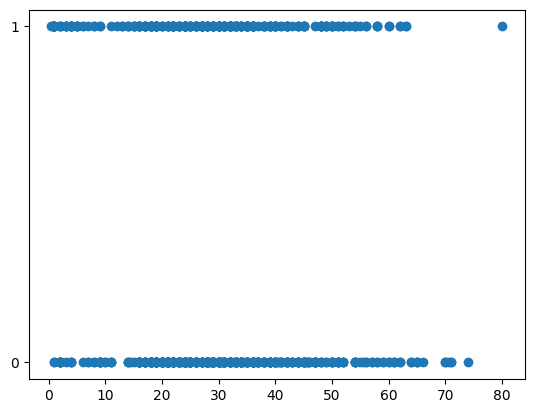

In [20]:
fig, ax = plt.subplots()
ax.scatter(train_df["Age"], train_df["Survived"])
ax.set_yticks([0, 1])
plt.show()

- 성별 생존 막대 그래프를 확인해본다. 
- 여성이 남성보다 상대적으로 더 많이 생존한 것을 알 수 있다. 

In [21]:
def plot_bar(data, column=None):
    if column is not None:
        fig, ax = plt.subplots(1, 2, figsize=(18, 8))
        data[[column, "Survived"]].groupby([column]).mean().plot.bar(ax=ax[0])
        ax[0].set_title(f"Survived vs {column}")
        sns.countplot(x = column, hue="Survived", data=data, ax=ax[1])
        ax[1].legend(labels = ["Dead", "Survived"])
        ax[1].set_title(f"{column}:Survived vs Dead")
    else:
        print("Please type your column")
        

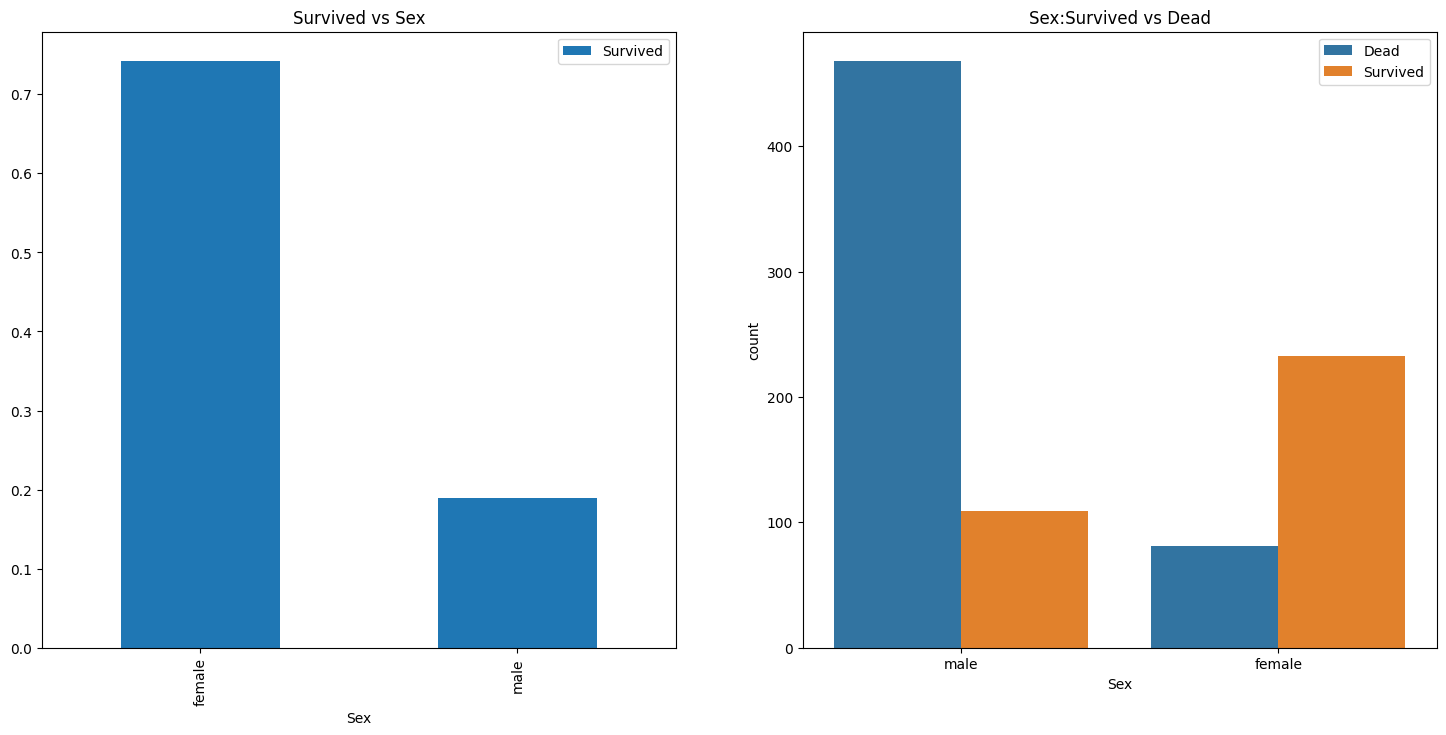

In [22]:
column_name = 'Sex'
plot_bar(train_df, column=column_name)

- 이번에는 Pclass 별 생존 유무 막대그래프를 그려본다. 
- 1 클래스에 속할수록 생존할 확률이 높은 것을 확인할 수 있다. 

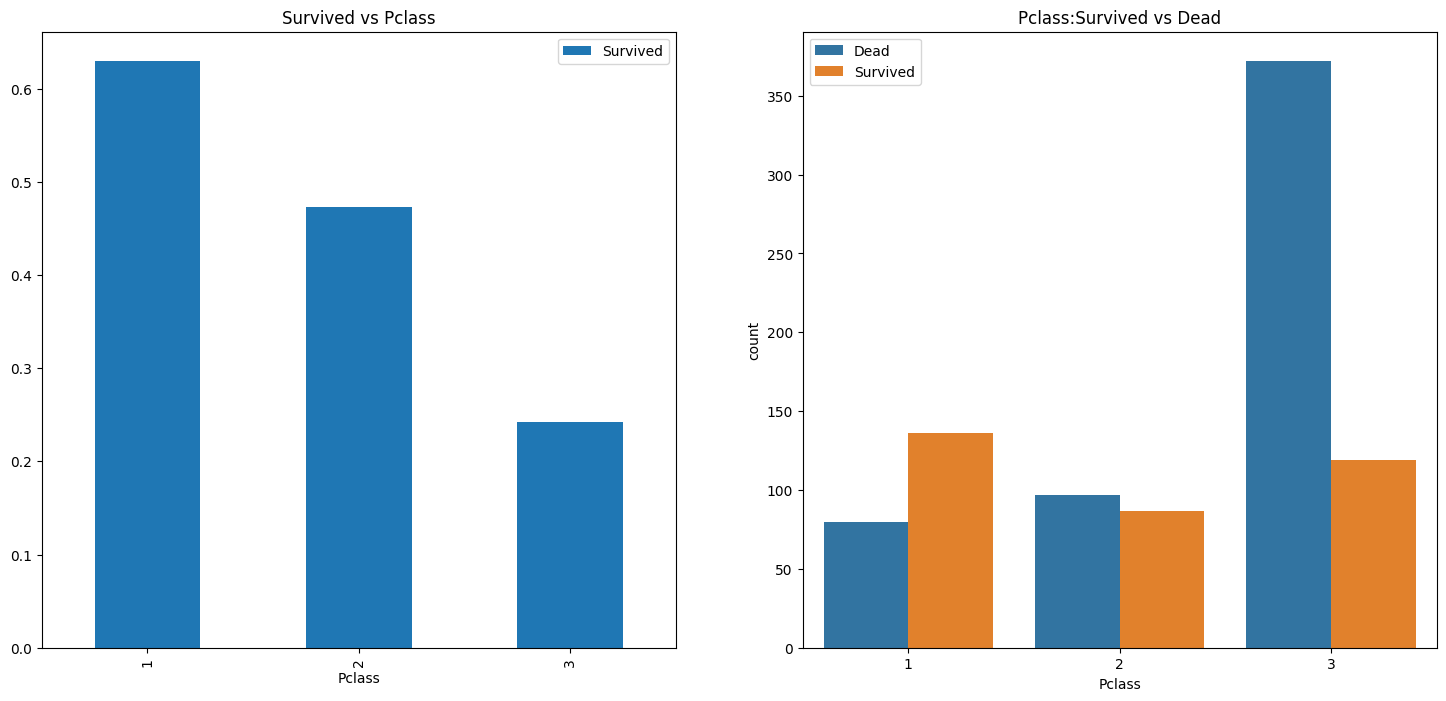

In [23]:
# 코드
column_name = 'Pclass'
plot_bar(train_df, column=column_name)

## AGE
- AGE의 평균을 일반적으로 대치하면 오차가 클 수 있다. 
- 이 때 Name Feature를 좀 더 분석하도록 하다. 

In [24]:
# 코드
train_df["Name"][:5]

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

- 데이터 특징을 보면, 첫번째 이름 뒤에 Mr. Mrs와 같은 호칭이 들어간 것을 확인할 수 있다. 
- 이를 기반으로 데이터를 추출한다.

In [25]:
import re

temp_test = "Heikkinen, Ms. Leina"
re.search("([A-Za-z]+)\.", temp_test).group(1)

'Ms'

In [26]:
# 코드
train_df['initial'] = 0
for _ in [train_df, test]:
    train_df['initial'] = train_df["Name"].str.extract("([A-Za-z]+)\.")
    test['initial'] = test['Name'].str.extract("([A-Za-z]+)\.")
    
train_df[['Name', 'initial']]

,Name,initial
0,"Braund, Mr. Owen Harris",Mr
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mrs
2,"Heikkinen, Miss. Laina",Miss
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Mrs
4,"Allen, Mr. William Henry",Mr
...,...,...
886,"Montvila, Rev. Juozas",Rev
887,"Graham, Miss. Margaret Edith",Miss
888,"Johnston, Miss. Catherine Helen ""Carrie""",Miss
889,"Behr, Mr. Karl Howell",Mr


- 집계를 해보도록 한다. 

In [27]:
# 코드
pd.crosstab(train_df["initial"], train_df["Sex"]).T

initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


In [28]:
# 코드
pd.crosstab(test['initial'], test['Sex']).T

initial,Col,Dona,Dr,Master,Miss,Mr,Mrs,Ms,Rev
Sex,,,,,,,,,
female,0,1,0,0,78,0,72,1,0
male,2,0,1,21,0,240,0,0,2


- 위 결과물을 바탕으로 그룹화를 진행한다. 

In [29]:
# 코드
b4_title = ['Mlle', 'Mme', 'Ms', 'Dr', 'Major', 'Lady', 'Countess', 'Jonkheer', 'Col', 'Rev', 'Capt', 'Sir', 'Don', 'Dona']
after_title = ['Miss', 'Miss', 'Miss', 'Mr', 'Mr', 'Mrs', 'Mrs', 'Other', 'Other', 'Other', 'Mr', 'Mr', 'Mr', 'Miss']

train_df['initial'] = train_df['initial'].replace(b4_title, after_title)
pd.crosstab(train_df["initial"], train_df["Sex"]).T

initial,Master,Miss,Mr,Mrs,Other
Sex,,,,,
female,0,186,1,127,0
male,40,0,528,0,9


In [30]:
# 코드
test['initial'] = test['initial'].replace(b4_title, after_title)
pd.crosstab(test['initial'], test['Sex']).T

initial,Master,Miss,Mr,Mrs,Other
Sex,,,,,
female,0,80,0,72,0
male,21,0,241,0,4


In [31]:
test.info()# 코드

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
 11  initial      418 non-null    object 
dtypes: float64(2), int64(4), object(6)
memory usage: 39.3+ KB


In [32]:
train_df.info()# 코드

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  initial      891 non-null    object 
dtypes: float64(2), int64(5), object(6)
memory usage: 90.6+ KB


- Initial 컬럼을 그룹화하여 Age의 평균을 계산한다. 

In [33]:
train_df.groupby('initial')['Age'].mean()

initial
Master     4.574167
Miss      21.860000
Mr        32.739609
Mrs       35.981818
Other     45.888889
Name: Age, dtype: float64

- 위 데이터를 근거로 Age의 결측치를 추가할 것이다. 

In [36]:
# 코드 train_df.loc[(조건식) & (조건식), 컬럼]
train_df.loc[(train_df['Age'].isnull()) & (train_df['initial'] == 'Mr'), 'Age']=33
train_df.loc[(train_df['Age'].isnull()) & (train_df['initial'] == 'Master'), 'Age']=5
train_df.loc[(train_df['Age'].isnull()) & (train_df['initial'] == 'Miss'), 'Age']=22
train_df.loc[(train_df['Age'].isnull()) & (train_df['initial'] == 'Mrs'), 'Age']=36
train_df.loc[(train_df['Age'].isnull()) & (train_df['initial'] == 'Other'), 'Age']=46

train_df['Age'].isnull().sum()

0

- 동일하게 test 데이터에도 적용을 해본다. 

In [37]:
# 코드
test.groupby('initial')['Age'].mean()

initial
Master     7.406471
Miss      22.039846
Mr        32.114130
Mrs       38.903226
Other     42.750000
Name: Age, dtype: float64

In [40]:
# 코드
test.loc[(train_df['Age'].isnull()) & (train_df['initial'] == 'Mr'), 'Age']=33
test.loc[(train_df['Age'].isnull()) & (train_df['initial'] == 'Master'), 'Age']=8
test.loc[(train_df['Age'].isnull()) & (train_df['initial'] == 'Miss'), 'Age']=22
test.loc[(train_df['Age'].isnull()) & (train_df['initial'] == 'Mrs'), 'Age']=39
test.loc[(train_df['Age'].isnull()) & (train_df['initial'] == 'Other'), 'Age']=43

test['Age'].isnull().sum()

86

In [44]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
initial          0
dtype: int64

In [42]:
test['Fare'] = test['Fare'].fillna(np.mean(test['Fare']))

In [43]:
test['Age'] = test['Age'].fillna(np.mean(test['Age']))

- Age 결측치가 존재하는지 확인해본다. 

In [45]:
# 코드
test['Age'].isnull().sum() 

0

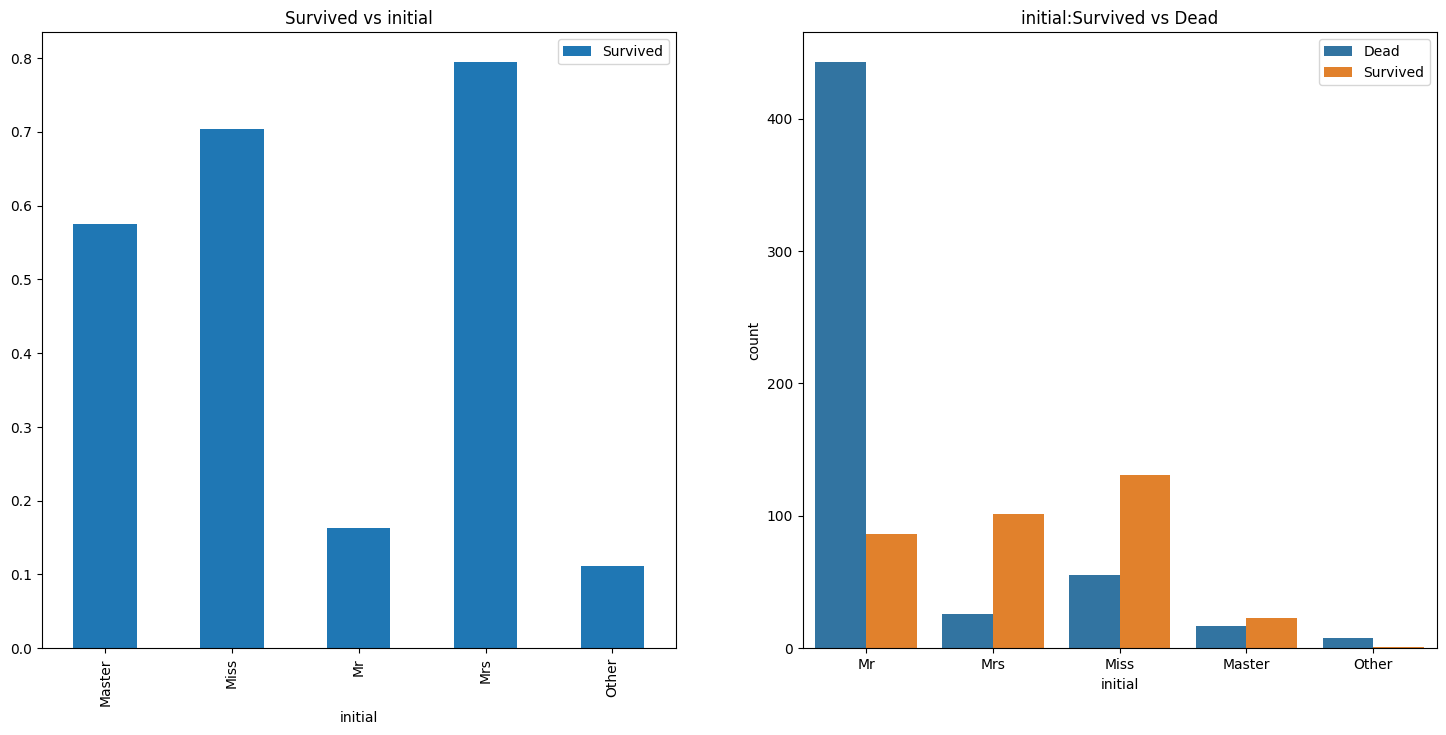

In [29]:
# 코드
column_name = 'initial'
plot_bar(train_df, column_name)

In [30]:
# 코드
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  initial      891 non-null    object 
dtypes: float64(2), int64(5), object(6)
memory usage: 90.6+ KB


In [31]:
# 코드
train_df['Embarked'].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

- Embarked 결측치의 경우, 2개 결측치만 존재하다. 
- 따라서, 빈도가 가장 많은 S로 대체하도록 하다. 

In [32]:
# 코드
train_df['Embarked'] = train_df['Embarked'].fillna('S')
train_df['Embarked'].isnull().sum()

0

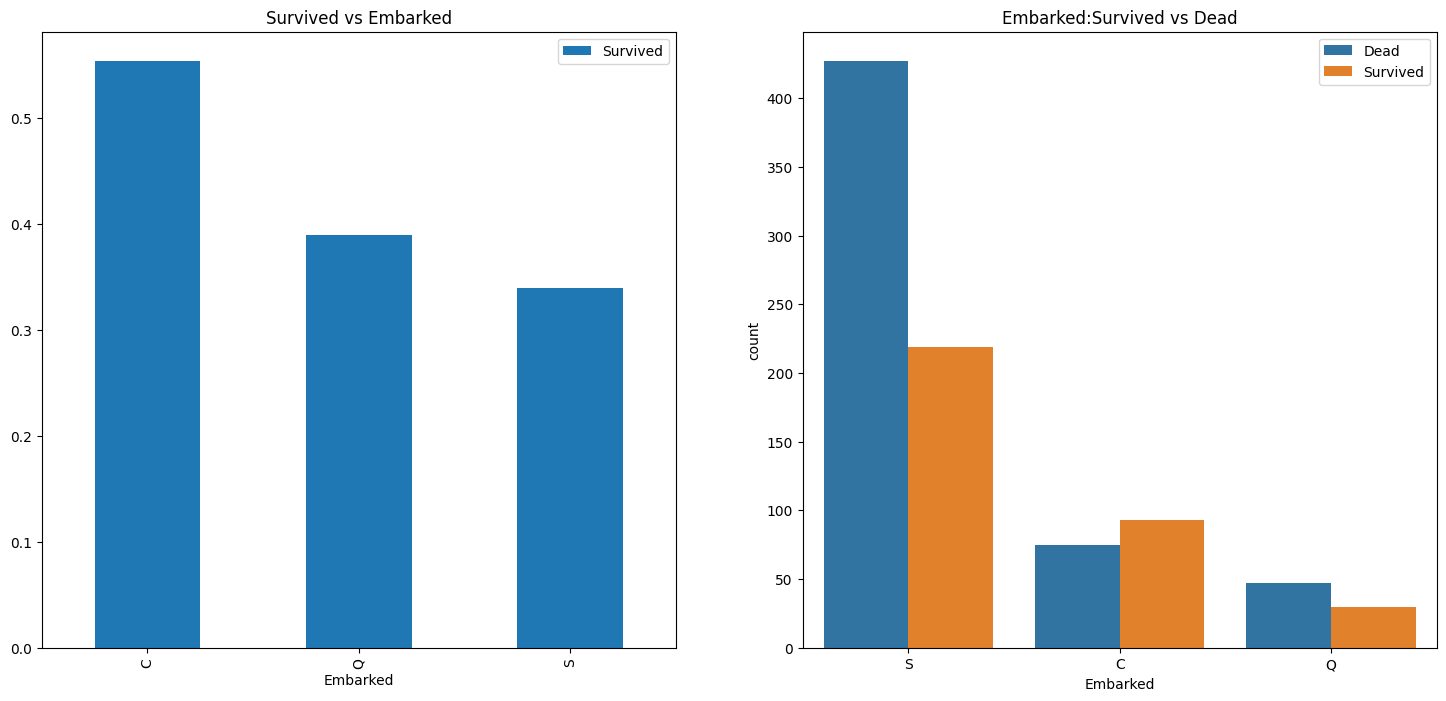

In [33]:
# 코드
column_name = 'Embarked'
plot_bar(train_df, column_name)

## Feature 제거
- 불필요한 컬럼을 제거하다. 
    + Name 대신에 Initial 피처를 생성했다. 
    + Ticket은 랜덤 문자열로 기록이 되어 있어서 제거했다. 
    + Cabin은 결측치가 존재해서 제거했다. 

In [34]:
# 코드
train_df['Ticket']

0             A/5 21171
1              PC 17599
2      STON/O2. 3101282
3                113803
4                373450
             ...       
886              211536
887              112053
888          W./C. 6607
889              111369
890              370376
Name: Ticket, Length: 891, dtype: object

In [35]:
# 코드
col = ['Name', 'Ticket', 'Cabin', 'PassengerId']
train_df = train_df.drop(col, axis=1)

In [36]:
train_df = pd.get_dummies(train_df)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Survived        891 non-null    int64  
 1   Pclass          891 non-null    int64  
 2   Age             891 non-null    float64
 3   SibSp           891 non-null    int64  
 4   Parch           891 non-null    int64  
 5   Fare            891 non-null    float64
 6   Sex_female      891 non-null    bool   
 7   Sex_male        891 non-null    bool   
 8   Embarked_C      891 non-null    bool   
 9   Embarked_Q      891 non-null    bool   
 10  Embarked_S      891 non-null    bool   
 11  initial_Master  891 non-null    bool   
 12  initial_Miss    891 non-null    bool   
 13  initial_Mr      891 non-null    bool   
 14  initial_Mrs     891 non-null    bool   
 15  initial_Other   891 non-null    bool   
dtypes: bool(10), float64(2), int64(4)
memory usage: 50.6 KB


In [37]:
test = test.drop(col, axis = 1)
test = pd.get_dummies(test)

In [38]:
train_df.shape, test.shape

((891, 16), (418, 15))

- 데이터셋 분리를 진행한다. 

In [39]:
# 코드
deceased = train_df[train_df['Survived'] == 0].sample(frac=0.5, random_state=42).reset_index(drop=True)
survived = train_df[train_df['Survived'] == 1]

deceased.shape, survived.shape

((274, 16), (342, 16))

In [40]:
from sklearn.model_selection import train_test_split
deceased_train, deceased_test = train_test_split(deceased, test_size = 0.2, random_state = 42)
survived_train, survived_test = train_test_split(survived, test_size = 0.2, random_state = 42)

deceased_train, deceased_validate = train_test_split(deceased_train, test_size=0.25, random_state=42)
survived_train, survived_validate = train_test_split(survived_train, test_size=0.25, random_state=42)

deceased_train.shape, deceased_validate.shape, survived_train.shape, survived_validate.shape

((164, 16), (55, 16), (204, 16), (69, 16))

In [41]:
X_train = pd.concat((deceased_train, survived_train))
X_test = pd.concat((deceased_test, survived_test))
X_validate = pd.concat((deceased_validate, survived_validate))

Y_train = np.array(X_train['Survived'])
Y_test = np.array(X_test['Survived'])
Y_validate = np.array(X_validate['Survived'])

X_train = X_train.drop("Survived", axis=1)
X_test = X_test.drop("Survived", axis=1)
X_validate = X_validate.drop("Survived", axis=1)

X_train.shape, X_validate.shape, X_test.shape, Y_train.shape, Y_validate.shape, Y_test.shape

((368, 15), (124, 15), (124, 15), (368,), (124,), (124,))

In [42]:
import mlflow
import mlflow.sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, RocCurveDisplay, confusion_matrix
print(mlflow.__version__)


2.7.1


In [43]:
def train(ml_model, X_train, Y_train):

    # 모형 학습
    ml_model = ml_model.fit(X_train, Y_train)
    train_acc = ml_model.score(X_train, Y_train) # 학습 데이터의 정확도
    mlflow.log_metric("train_acc", train_acc)
    print(f"Train Acc : {train_acc: .3%}")

def evaluate(ml_model, X_test, Y_test):
    eval_acc = ml_model.score(X_test, Y_test)
    preds = ml_model.predict(X_test)
    auc_score = roc_auc_score(Y_test, preds)
    mlflow.log_metric("eval_acc", eval_acc)
    mlflow.log_metric("auc_score", auc_score)
    print(f"Evaluation Acc : {eval_acc:.3%}")
    print(f"AUC Score : {auc_score:.3%}")

    # 결과 시각화 - ROC Curve
    roc_plot = RocCurveDisplay.from_estimator(ml_model, X_test, Y_test, name="Scikit-Learn ROC Curve")
    plt.savefig("sklearn_roc_plot.png")
    plt.show()
    plt.clf()
    mlflow.log_artifact("sklearn_roc_plot.png")

    # 결과 시각화 - 혼동행렬 그래프
    conf_matrix = confusion_matrix(Y_test, preds)
    ax = sns.heatmap(conf_matrix, annot=True, fmt = 'g')
    ax.invert_xaxis()
    ax.invert_yaxis()
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.title("Confusion Matrix")
    plt.savefig("sklearn_conf_matrix.png")
    mlflow.log_artifact("sklearn_conf_matrix.png")


## MLFlow 학습 및 평가
- MLFLOW 기능을 추가할 수 있는 사용자 정의 함수 구혀

In [44]:
# 코드

### 테스트 
- MLFLow 실행 로깅 및 확이하느 코드를 실행한다. 

Train Acc :  78.261%
Evaluation Acc : 79.839%
AUC Score : 78.748%


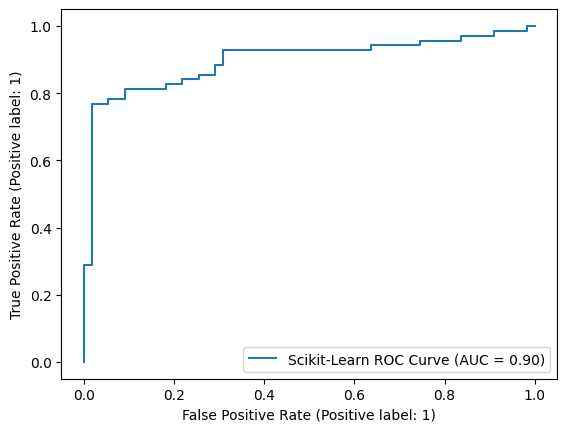

Model run:  9ee99a14c5f342a3ab137a5a12d0b3d0


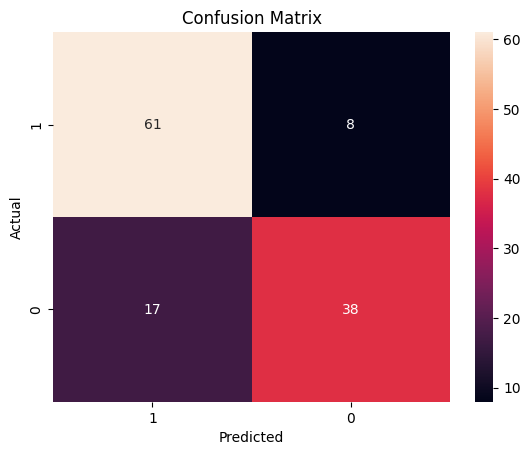

In [45]:
# 코드
ml_model = LogisticRegression(random_state = None, max_iter = 400, solver = 'newton-cg')

# 실험 이름 설정
mlflow.set_experiment("sklearn_logistic_experiment")

# 해당 이름으로 실험 배치
with mlflow.start_run():
    train(ml_model, X_train, Y_train)
    evaluate(ml_model, X_test, Y_test)

    mlflow.sklearn.log_model(ml_model, 'log_model')

    print("Model run: ", mlflow.active_run().info.run_uuid)
mlflow.end_run()

## mlflow 모델 불러오기
- 모델이 저장된 mlflow에서 모형을 가져오 후, test에 적용한다. 
- 실제 제출까지 진행한다. 

In [46]:
# 코드
ml_run_id = logged_model = 'runs:/48a86c89de0045efb76e4a1998000ac5/log_model'
loaded_model = mlflow.sklearn.load_model(ml_run_id)

# 예측
final_preds = loaded_model.predict(test)
submission["Survived"] = final_preds
submission.to_csv(DATA_PATH + "submission.csv", index=False)

## MLFLow 하이퍼 파라미터 튜닝
- 이번에는 하이퍼 파라미터 튜닝을 진행한다. 

In [47]:
## ML FLOW 하이퍼 파라미터 튜닝 
- 이번에는 하이퍼 파리미터 튜닝을 진행.
- 어떤 옵션이 직관적으로 좋은지 빠르게 판단할 수 없기에 하이퍼 파라미터 튜닝을 하는 것임.
- max death
- Grid Search, Random Search와 다양한 옵션이 있음.

SyntaxError: invalid syntax (3789792709.py, line 2)

In [49]:
# 코드
mlflow.set_experiment('sklearn_logistic_hyper_experiment')
survived_weights = [3,5,7,10]
logs = []


with mlflow.start_run():
    for idx in range(len(survived_weights)):
        weight = survived_weights[idx]

        # 파라미터 값을 mlflow에 저장
        mlflow.log_param("survived_weight", weight)
        class_weights = {0:1, 1:weight}
        sk_model = LogisticRegression(random_state=42, max_iter=400, solver='newton-cg', class_weight=class_weights)
        sk_model.fit(X_validate, Y_validate)

        for h in range(40): print('-', end="")
        print(f"\nSurvived Weight : {weight}")

        # train acc에 mlflow에 적재(Logging)
        train_accuracy = sk_model.score(X_train, Y_train)
        mlflow.log_metric("train_accuracy", train_accuracy)
        
        # validation auc
        valid_accuracy = sk_model.score(X_validate, Y_validate)
        preds = sk_model.predict(X_validate)
        validation_auc_score = roc_auc_score(Y_validate, preds)

        mlflow.log_metric("evaluation_accuracy", valid_accuracy)
        mlflow.log_metric("evaluation_accuracy", validation_auc_score)
        
        # test auc
        test_accuracy = sk_model.score(X_test, Y_test)
        preds = sk_model.predict(X_test)
        test_auc_score = roc_auc_score(Y_test, preds)

        mlflow.log_metric("test_accuracy", test_accuracy)
        mlflow.log_metric("test_auc_score", test_auc_score)

        print("evluation Auc:{}".format(validation_auc_score))
        
        log = [sk_model, X_validate, Y_validate, preds]
        logs.append(log)

        # 각 모델을 mlflow에 적재(Logging)
        mlflow.sklearn.log_model(sk_model, f"survived_weight_{weight}")
        mlflow.end_run()

----------------------------------------
Survived Weight : 3
evluation Auc:0.7237154150197629


C:\Users\MSYUN\Desktop\ml_optuna_mlflow\venv\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\MSYUN\Desktop\ml_optuna_mlflow\venv\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


----------------------------------------
Survived Weight : 5
evluation Auc:0.6745718050065876


C:\Users\MSYUN\Desktop\ml_optuna_mlflow\venv\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\MSYUN\Desktop\ml_optuna_mlflow\venv\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


----------------------------------------
Survived Weight : 7
evluation Auc:0.6363636363636364


C:\Users\MSYUN\Desktop\ml_optuna_mlflow\venv\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\MSYUN\Desktop\ml_optuna_mlflow\venv\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


----------------------------------------
Survived Weight : 10
evluation Auc:0.5727272727272728


C:\Users\MSYUN\Desktop\ml_optuna_mlflow\venv\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\MSYUN\Desktop\ml_optuna_mlflow\venv\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
